<a href="https://colab.research.google.com/github/fabrytp8/AG1/blob/main/regresion/Programa14_Regresion_KNN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from math import sqrt
from sklearn import datasets
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectPercentile
# from evaluacion_funciones import *

In [4]:
# Carga de datos.
dataset = datasets.load_boston()
X = dataset.data
y = dataset.target
print(np.shape(X))

(506, 13)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [5]:
# Métricas de evaluación.
metricas = {
  'MAE':  metrics.mean_absolute_error,
  'RMSE': lambda y, y_pred:
          sqrt(metrics.mean_squared_error(y, y_pred)),
  'MAPE': lambda y, y_pred:
          np.mean(np.abs((y - y_pred) / y)) * 100,
  'R2':   metrics.r2_score}

In [6]:
# Construcción de los algoritmos de aprendizaje.
k = 10
base = 'KNN' + str(k)
algoritmos = {}

In [7]:
# Algoritmo 1: KNN
algoritmos[base] = KNeighborsRegressor(n_neighbors = k)

In [8]:
# Algoritmo 2: Estandarización + KNN
pasos = [('estandarizacion', StandardScaler()),
         ('reg', algoritmos['KNN'+str(k)])]
algoritmos['Est+'+base] = Pipeline(pasos)

In [9]:
# Algoritmo 3: Estandarización + Selección atributos + KNN
pasos = [('estandarizacion', StandardScaler()),
         ('selatr', SelectPercentile(score_func=f_regression, percentile=10)),
         ('reg', algoritmos['KNN'+str(k)])]
algoritmos['Est+SelAtr+'+base] = Pipeline(pasos)

In [10]:
# Algoritmo 4: Estandarización + Selecc. atributos + KNN(p=1)
pasos = [('estandarizacion', StandardScaler()),
         ('selatr', SelectPercentile(score_func=f_regression,
           percentile=10)),
         ('reg', KNeighborsRegressor(n_neighbors = k, p=1))]
algoritmos['Est+SelAtr+'+base+'(p=1)'] = Pipeline(pasos)

In [11]:
# Validación y obtención de las predicciones del modelo.
y_pred = {}
for nombre, alg in algoritmos.items():
    y_pred[nombre] = cross_val_predict(alg, X, y, cv=KFold(n_splits=10, shuffle=True,random_state=42))

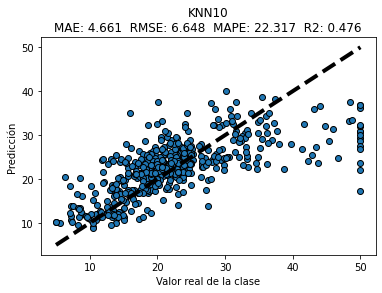

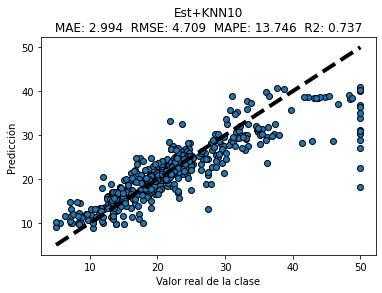

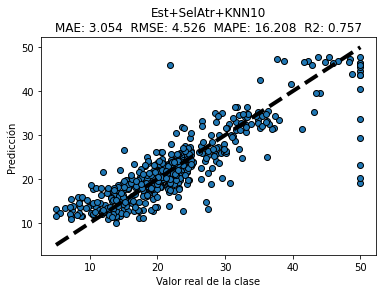

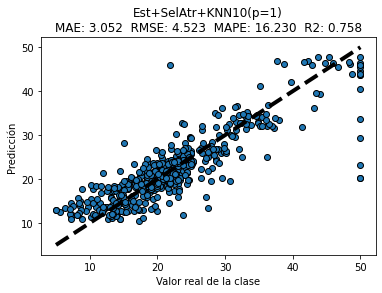

In [12]:
# Evaluación y presentación de resultados.
for nombre, alg in algoritmos.items():
    results = evaluacion(y, y_pred[nombre], metricas)
    grafica_real_vs_pred(y, y_pred[nombre], results, nombre)

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree
import graphviz


# Calculo de las metricas de evaluacion.
def evaluacion(y_true, y_pred, metricas):
    res = {}
    for nombre, funcion in metricas.items():
        res[nombre] = funcion(y_true, y_pred)
    return res

# Grafica de realidad -vs- prediccion.
def grafica_real_vs_pred(y_true, y_pred, metricas, algoritmo):
    fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred, edgecolors=(0, 0, 0))
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    ax.set_xlabel('Valor real de la clase')
    ax.set_ylabel('Predicción')
    plt.title("%s\nMAE: %.3f  RMSE: %.3f  MAPE: %.3f  R2: %.3f" %
              (algoritmo,metricas['MAE'],metricas['RMSE'],metricas['MAPE'],metricas['R2']))
    plt.show()

# Grafica con mapa de regiones de clasificacion segun modelo ya entrenado que admita coef_ e intercept_.
def mapa_modelo_clasif_2d(X, y, modelo, metricas, algoritmo):
    # create a mesh to plot in
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = modelo.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(20,16))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.title("%s\nACC: %.3f  PREC: %.3f  RECALL: %.3f  F1: %.3f" %
              (algoritmo,metricas['ACC'],metricas['PREC'],metricas['RECALL'],metricas['F1']), fontsize=28)
    plt.axis('tight')

    # Plot also the training points
    colors = "bry"
    for i, color in zip(modelo.classes_, colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired,
                    edgecolor='black', s=20)

    # Plot the three one-against-all classifiers
    if (hasattr(modelo, 'coef_')):
        xmin, xmax = plt.xlim()
        ymin, ymax = plt.ylim()
        coef = modelo.coef_
        intercept = modelo.intercept_

        def plot_hyperplane(c, color):
            def line(x0):
                return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]

            plt.plot([xmin, xmax], [line(xmin), line(xmax)],
                     ls="--", color=color)

        for i, color in zip(modelo.classes_, colors):
            plot_hyperplane(i, color)

    plt.show()

# Visualizacion de modelo de tipo arbol.
def mostrar_modelo_arbol(modelo, datos, nombre_archivo = "modelo"):
    dot_data = tree.export_graphviz(modelo, out_file=None, feature_names=datos.feature_names,
                         class_names=datos.target_names, filled=True,
                         rounded=True, special_characters=True)

    graph = graphviz.Source(dot_data)
    graph.render(nombre_archivo, view=True)